In [1]:
import pandas as pd

In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


## Loading the Data

In [3]:
url1 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" # confirmed cases day by day
url2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv" # deaths
url3 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv" # recovery day by day

covid_confirmed = pd.read_csv(url1) # main df to work with
covid_death = pd.read_csv(url2) 
covid_recovered = pd.read_csv(url3)

print(covid_death.head())

  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...     7896    7896    7896    7896   
1        0        0        0        0  ...     3598    3598    3598    3598   
2        0        0        0        0  ...     6881    6881    6881    6881   
3        0        0        0        0  ...      165     165     165     165   
4        0        0        0        0  ...     1933    1933    1933    1933   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0    7896    7896    7896   

In [4]:
covid_confirmed[covid_confirmed['Country/Region'] == 'US']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
260,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,103443455,103533872,103589757,103648690,103650837,103646975,103655539,103690910,103755771,103802702


#### Very few null entries, whereas there are a lot of columns for each day
Lets zoom in on a country in particular, the US

In [5]:
df_us = covid_confirmed[covid_confirmed['Country/Region'] == 'US'].drop(columns=['Lat', 'Long', 'Country/Region', 'Province/State'], errors='ignore') # drop columns that are not necessary 
daily_cases = df_us.sum(axis=0).diff().fillna(0) # difference of cases from col to col
daily_cases.index = pd.to_datetime(daily_cases.index) # columns to actual datetime objects, proper date handling for plotting and modelling
daily_cases = daily_cases.to_frame(name='new_cases_diff_by_day') # daily cases series to df w single col named new_cases

C:\Users\ragha\AppData\Local\Temp\ipykernel_8992\4202040389.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_cases.index = pd.to_datetime(daily_cases.index) # columns to actual datetime objects, proper date handling for plotting and modelling


In [6]:
df_us_cumulative = df_us.sum(axis=0) # add all US rows, cumulative sum
df_us_cumulative.index = pd.to_datetime(df_us_cumulative.index)

C:\Users\ragha\AppData\Local\Temp\ipykernel_8992\3013755368.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_us_cumulative.index = pd.to_datetime(df_us_cumulative.index)


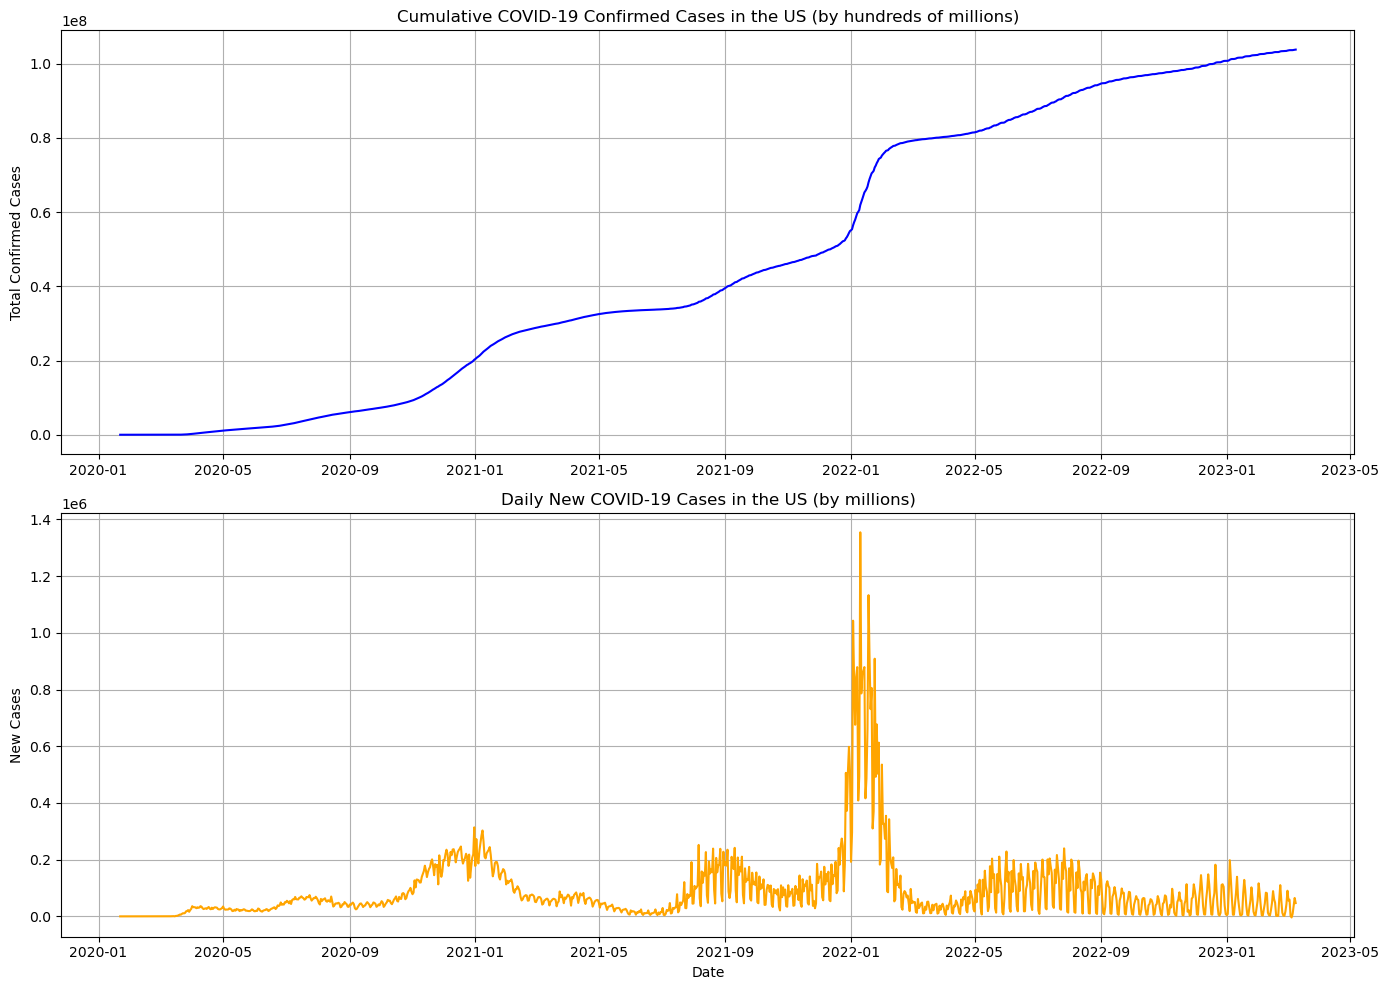

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# --- Plot 1: Cumulative cases ---
plt.subplot(2, 1, 1)  # (nrows, ncols, index)
plt.plot(df_us_cumulative.index, df_us_cumulative.values, color='blue')
plt.title("Cumulative COVID-19 Confirmed Cases in the US (by hundreds of millions)")
plt.ylabel("Total Confirmed Cases")
plt.grid(True)

# --- Plot 2: Daily new cases ---
plt.subplot(2, 1, 2)
plt.plot(daily_cases.index, daily_cases["new_cases_diff_by_day"], color='orange')
plt.title("Daily New COVID-19 Cases in the US (by millions)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
#covid_confirmed 
#covid_death
covid_recovered 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
270,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Compare to New Zealand which was said to have a better resonse to COVID, having one of the lowest death rates to COVID in the world. 



In [9]:
df_nz = covid_confirmed[covid_confirmed['Country/Region'] == 'New Zealand'].drop(columns=['Lat', 'Long', 'Country/Region', 'Province/State'], errors='ignore') # drop columns that are not necessary 
daily_cases_nz = df_nz.sum(axis=0).diff().fillna(0) # difference of cases from col to col
daily_cases_nz.index = pd.to_datetime(daily_cases_nz.index) # columns to actual datetime objects, proper date handling for plotting and modelling
daily_cases_nz = daily_cases_nz.to_frame(name='new_cases_diff_by_day') # daily cases series to df w single col named new_cases

C:\Users\ragha\AppData\Local\Temp\ipykernel_8992\3380096095.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_cases_nz.index = pd.to_datetime(daily_cases_nz.index) # columns to actual datetime objects, proper date handling for plotting and modelling


In [10]:
daily_cases_nz

,new_cases_diff_by_day
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2023-03-05,11439.0
2023-03-06,2.0
2023-03-07,0.0
2023-03-08,0.0


In [11]:
df_nz_cumulative = df_nz.sum(axis=0) # add all US rows, cumulative sum
df_nz_cumulative.index = pd.to_datetime(df_nz_cumulative.index)

C:\Users\ragha\AppData\Local\Temp\ipykernel_8992\4072935482.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_nz_cumulative.index = pd.to_datetime(df_nz_cumulative.index)


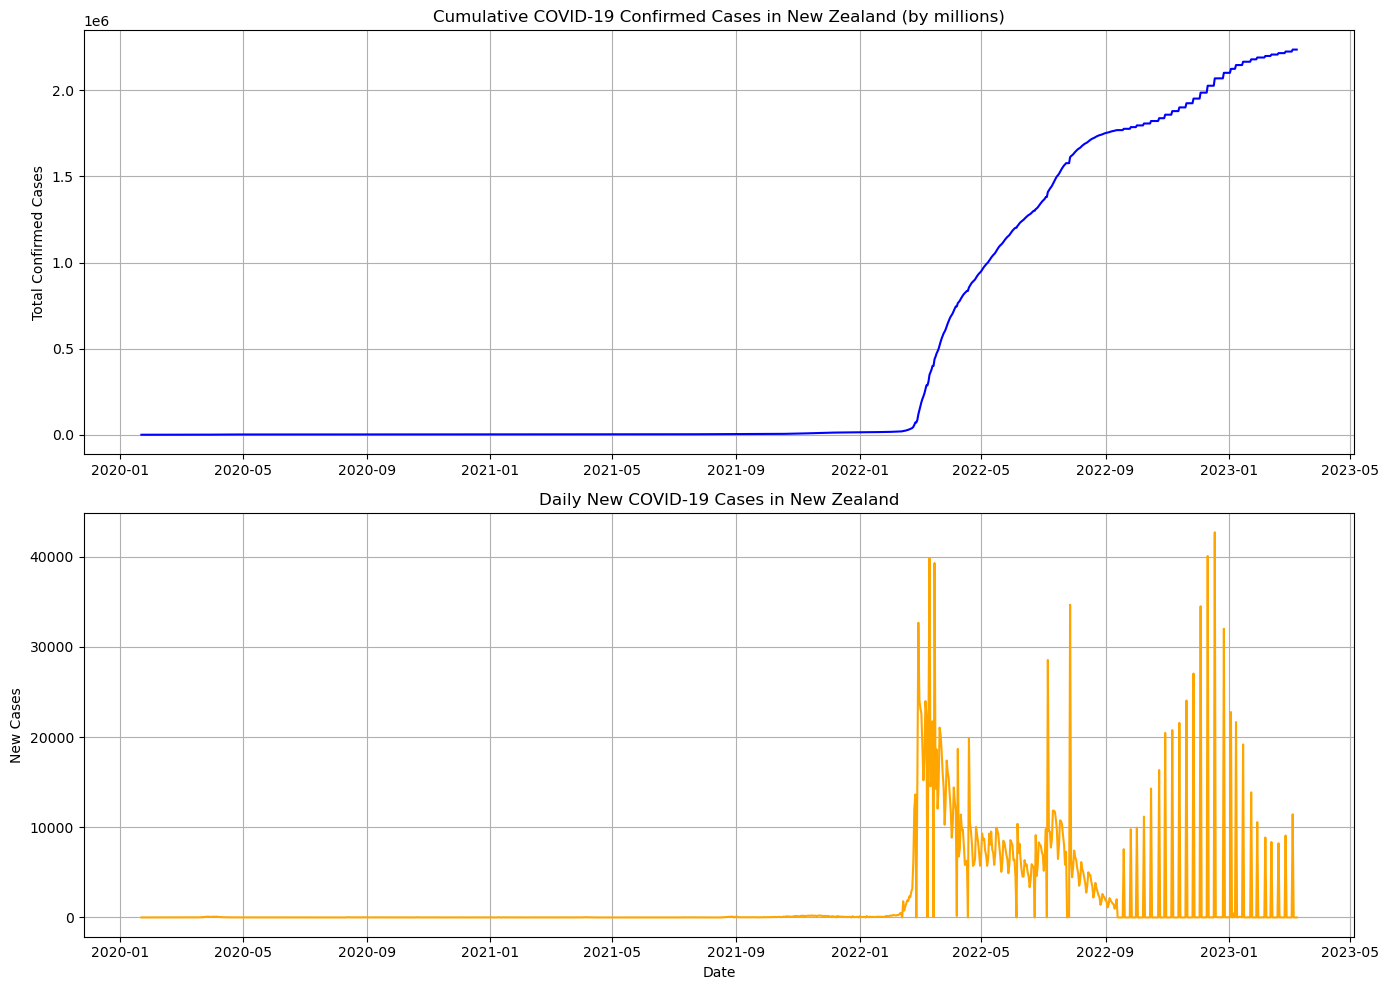

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# --- Plot 1: Cumulative cases ---
plt.subplot(2, 1, 1)  # (nrows, ncols, index)
plt.plot(df_nz_cumulative.index, df_nz_cumulative.values, color='blue')
plt.title("Cumulative COVID-19 Confirmed Cases in New Zealand (by millions)")
plt.ylabel("Total Confirmed Cases")
plt.grid(True)

# --- Plot 2: Daily new cases ---
plt.subplot(2, 1, 2)
plt.plot(daily_cases_nz.index, daily_cases_nz["new_cases_diff_by_day"], color='orange')
plt.title("Daily New COVID-19 Cases in New Zealand")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.grid(True)

plt.tight_layout()
plt.show()

### Rolling Averages comparison of US and NZ

In [ ]:
us_rolling = daily_cases.rolling(window=7).mean()
nz_rolling = daily_cases_nz.rolling(window=7).mean()

# rollingaverage to smooth out spikes and noise, see trendlines a bit mroe clearly and concisely


,new_cases_diff_by_day
2020-01-22,NaN
2020-01-23,NaN
2020-01-24,NaN
2020-01-25,NaN
2020-01-26,NaN
...,...
2023-03-05,37744.571429
2023-03-06,36530.285714
2023-03-07,35350.714286
2023-03-08,31699.857143


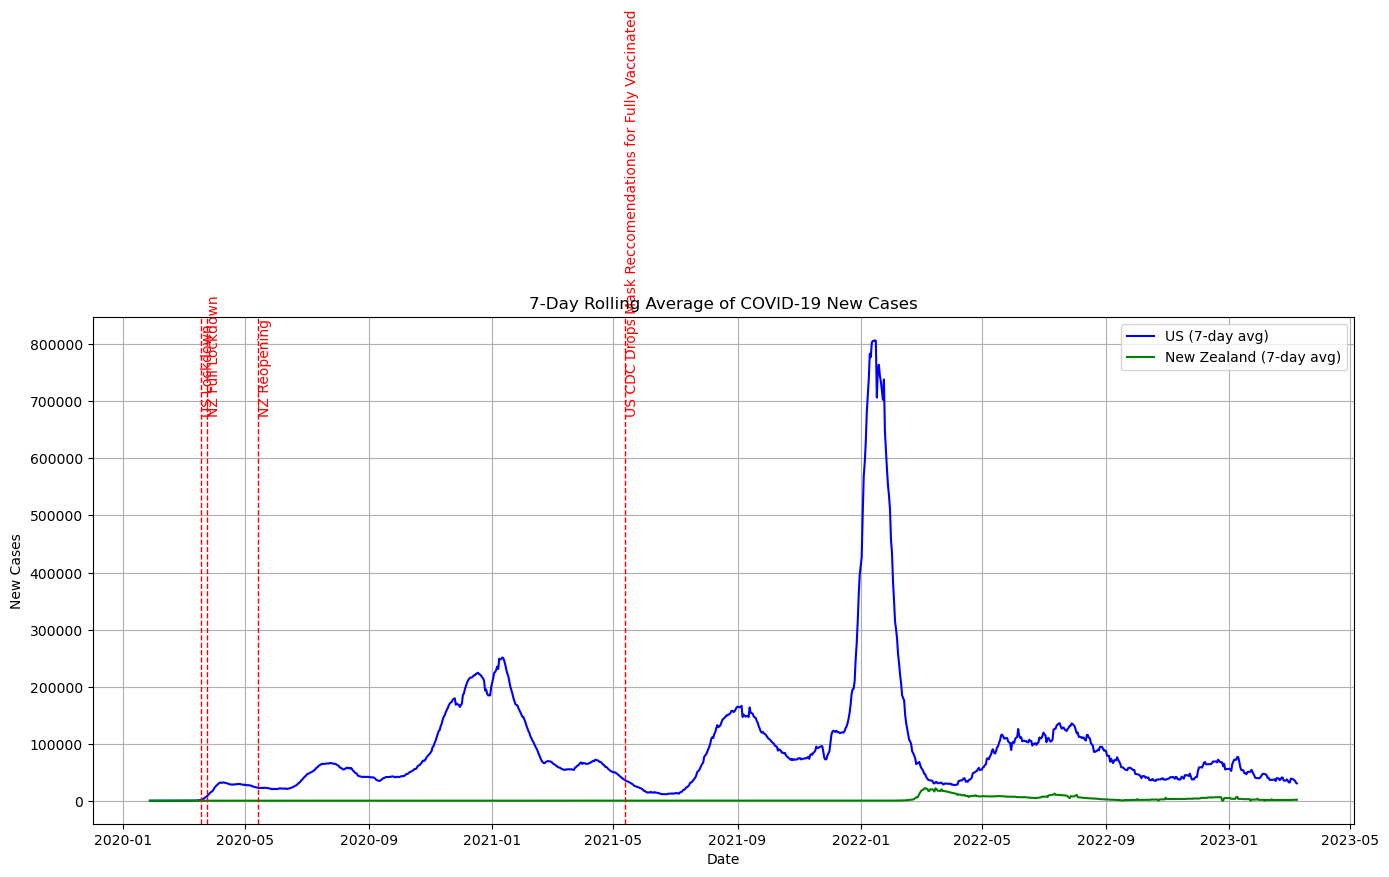

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(us_rolling.index, us_rolling['new_cases_diff_by_day'], label='US (7-day avg)', color='blue')
plt.plot(nz_rolling.index, nz_rolling['new_cases_diff_by_day'], label='New Zealand (7-day avg)', color='green')
plt.title("7-Day Rolling Average of COVID-19 New Cases")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()

lockdown_dates = {
    'US Lockdown': '2020-03-19',
    'NZ Full Lockdown': '2020-03-25',
    'NZ Reopening': '2020-05-14',
    'US CDC Drops Mask Reccomendations for Fully Vaccinated': '2021-05-13'
}

for label, date in lockdown_dates.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1)
    plt.text(pd.to_datetime(date), plt.ylim()[1]*0.8, label, rotation=90, color='red')

plt.show()



Rolling average shows covid daily spikes as well as some key time indices

#### Deep dive into Stringency Index and covid cases together 
Stringency refers to a scale on governments policy strictness regarding COVID 19

In [23]:
owid_url = "https://covid.ourworldindata.org/data/owid-covid-data.csv" # our world in data COVID dataset (stringency index)
owid = pd.read_csv(owid_url, parse_dates=['date'])

In [24]:
stringency_us = owid[owid['location'] == 'United States'][['date', 'stringency_index']].set_index('date')
stringency_nz = owid[owid['location'] == 'New Zealand'][['date', 'stringency_index']].set_index('date')

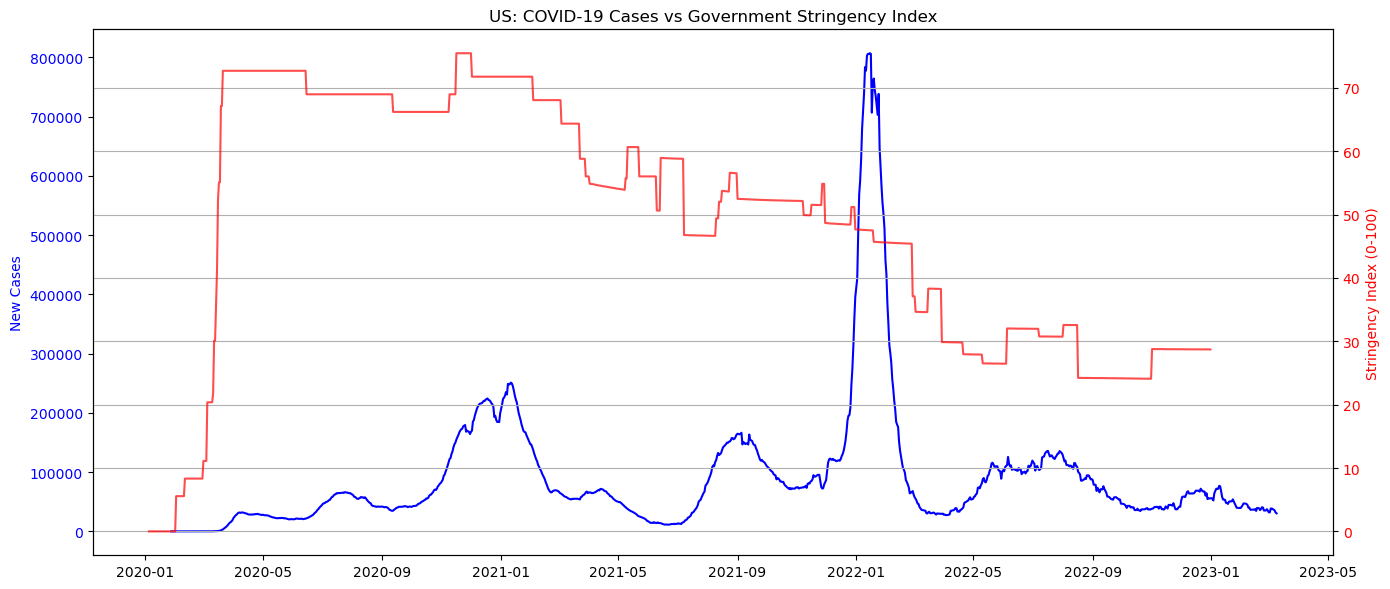

In [37]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(us_rolling.index, us_rolling['new_cases_diff_by_day'], label='US New Cases (7-day avg)', color='blue')
ax1.set_ylabel('New Cases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(stringency_us.index, stringency_us['stringency_index'], label='Stringency Index', color='red', alpha=0.7)
ax2.set_ylabel('Stringency Index (0-100)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("US: COVID-19 Cases vs Government Stringency Index")
fig.tight_layout()
plt.grid(True)

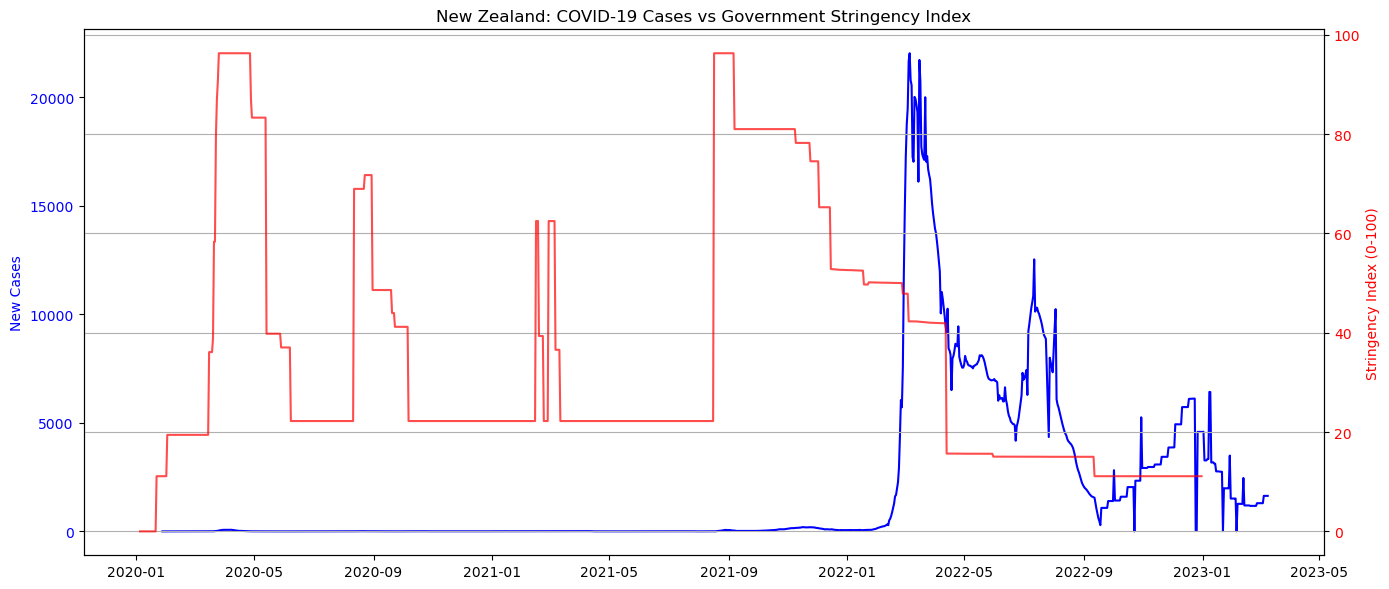

In [38]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(us_rolling.index, nz_rolling['new_cases_diff_by_day'], label='NZ New Cases (7-day avg)', color='blue')
ax1.set_ylabel('New Cases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(stringency_nz.index, stringency_nz['stringency_index'], label='Stringency Index', color='red', alpha=0.7)
ax2.set_ylabel('Stringency Index (0-100)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("New Zealand: COVID-19 Cases vs Government Stringency Index")
fig.tight_layout()
plt.grid(True)

With relaxed policies, there do seem to be spikes in cases occurring after the ralaxation in accordance to the strignency index. Could be used as a possible feature in the model! We can combine the dataframes as such

In [63]:
us_combined = daily_cases.join(stringency_us, how='left')
nz_combined = daily_cases_nz.join(stringency_nz, how='left')

us_combined['stringency_index'] = us_combined['stringency_index'].ffill()
nz_combined['stringency_index'] = nz_combined['stringency_index'].ffill()
# we added new column regarding stringency index , utilizing missigness imputation of assuming stringency stays the same since NAN

In [64]:
columns = [
    'date', 'location', 'new_cases', 'stringency_index',
    'people_vaccinated_per_hundred'
] # possible features form OWID dataset

owid_filtered = owid[columns] # 

us_df = owid_filtered[owid_filtered['location'] == 'United States'].copy()
nz_df = owid_filtered[owid_filtered['location'] == 'New Zealand'].copy()

us_df

,date,location,new_cases,stringency_index,people_vaccinated_per_hundred
403451,2020-01-05,United States,0.0,0.0,NaN
403452,2020-01-06,United States,0.0,0.0,NaN
403453,2020-01-07,United States,0.0,0.0,NaN
403454,2020-01-08,United States,0.0,0.0,NaN
403455,2020-01-09,United States,0.0,0.0,NaN
...,...,...,...,...,...
405120,2024-07-31,United States,NaN,NaN,NaN
405121,2024-08-01,United States,NaN,NaN,NaN
405122,2024-08-02,United States,NaN,NaN,NaN
405123,2024-08-03,United States,NaN,NaN,NaN


In [65]:


us_df.drop(columns=['location'], inplace=True)
nz_df.drop(columns=['location'], inplace=True)

us_df.set_index('date', inplace=True)
nz_df.set_index('date', inplace=True)

us_df.ffill()
nz_df.ffill() # forward fill for time series data (impute using previous values and continuing forward)

,new_cases,stringency_index,people_vaccinated_per_hundred
date,,,
2020-01-05,0.0,0.00,NaN
2020-01-06,0.0,0.00,NaN
2020-01-07,0.0,0.00,NaN
2020-01-08,0.0,0.00,NaN
2020-01-09,0.0,0.00,NaN
...,...,...,...
2024-08-07,1730.0,11.11,82.97
2024-08-08,1730.0,11.11,82.97
2024-08-09,1730.0,11.11,82.97


In [ ]:
us_df['new_cases'] = us_df['new_cases'].rolling(window=7).mean().fillna(0)
nz_df['new_cases'] = nz_df['new_cases'].rolling(window=7).mean().fillna(0) # rolling average to smooth out noise and spikes and irregular values

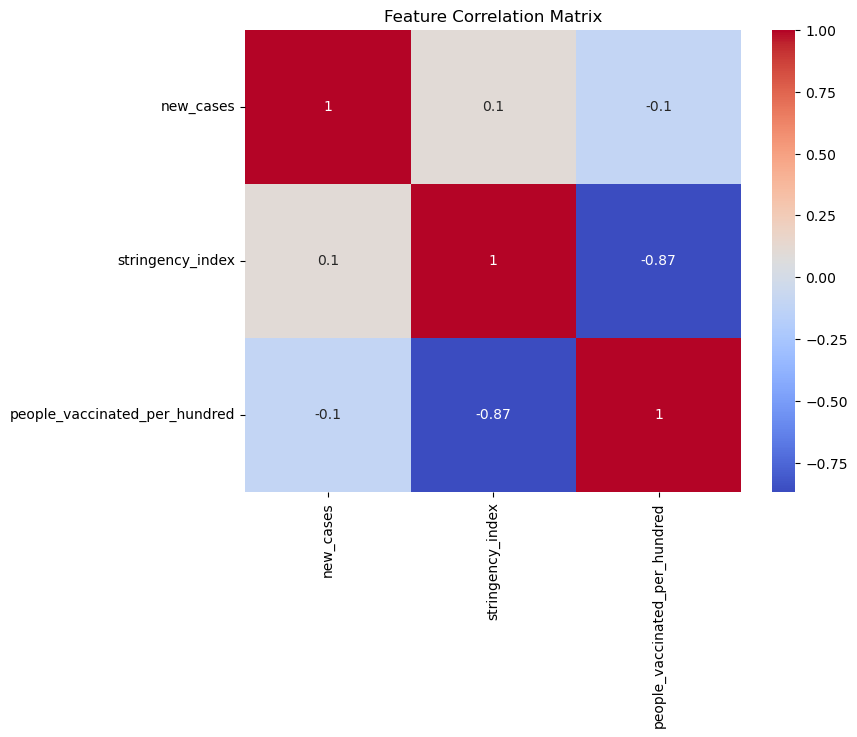

In [ ]:
import seaborn as sns
# visualize correlations with heat matrix
corr = us_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

<Axes: xlabel='stringency_index', ylabel='new_cases'>

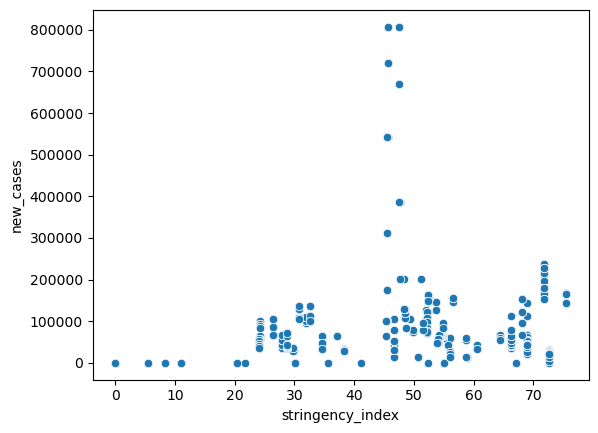

In [68]:
sns.scatterplot(x=us_df['stringency_index'], y=us_df['new_cases'])

<Axes: xlabel='stringency_index', ylabel='new_cases'>

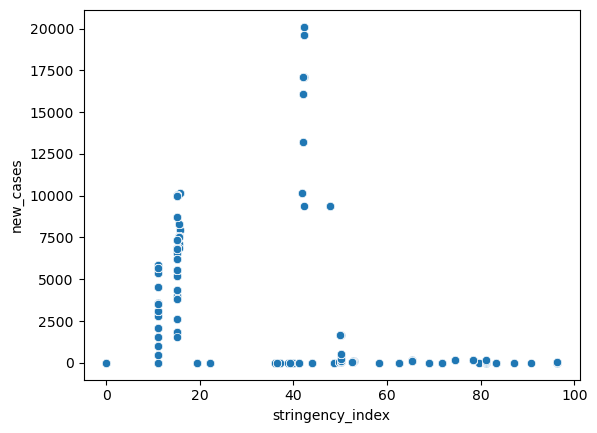

In [69]:
sns.scatterplot(x=nz_df['stringency_index'], y=nz_df['new_cases'])

In [70]:
# TODO 
# normalize the features
# create sliding window sequences for TF to predict upon

In [74]:
us_df.isnull().sum()

new_cases                          0
stringency_index                 582
people_vaccinated_per_hundred    796
dtype: int64

In [73]:
nz_df.isnull().sum()

new_cases                          0
stringency_index                 589
people_vaccinated_per_hundred    876
dtype: int64

### Start fully cleaning NAN and normalizing the features to be used in our model, use Forward Fill on time series data

In [ ]:
us_df = us_df.ffill()
us_df = us_df.bfill()

,new_cases,stringency_index,people_vaccinated_per_hundred
date,,,
2020-01-05,0.0,0.00,0.01
2020-01-06,0.0,0.00,0.01
2020-01-07,0.0,0.00,0.01
2020-01-08,0.0,0.00,0.01
2020-01-09,0.0,0.00,0.01
...,...,...,...
2024-07-31,0.0,28.71,81.39
2024-08-01,0.0,28.71,81.39
2024-08-02,0.0,28.71,81.39


In [ ]:
nz_df = nz_df.ffill()
nz_df = nz_df.bfill()


,new_cases,stringency_index,people_vaccinated_per_hundred
date,,,
2020-01-05,0.0,0.00,0.00
2020-01-06,0.0,0.00,0.00
2020-01-07,0.0,0.00,0.00
2020-01-08,0.0,0.00,0.00
2020-01-09,0.0,0.00,0.00
...,...,...,...
2024-08-07,0.0,11.11,82.97
2024-08-08,0.0,11.11,82.97
2024-08-09,0.0,11.11,82.97


#### Normalize with Min Max Scaler and doesnt change data distribution / centering around 0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [94]:
us_scaled = pd.DataFrame(scaler.fit_transform(us_df), columns=us_df.columns, index=us_df.index)
nz_scaled = pd.DataFrame(scaler.fit_transform(nz_df), columns=nz_df.columns, index=nz_df.index)

#### Sliding Windows in Tensor Flow -
For time series models (LSTMs and GRUs) converts a continuous time series into overlapping sequences of fixed size for the model to learn from

In [102]:
import numpy as np

def create_sliding_windows(data, target_col='new_cases', window_size=14):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data.iloc[i:i+window_size].values # window of past values
        target = data.iloc[i+window_size][target_col] # target for prediction
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

In [ ]:
X, y = create_sliding_windows(us_scaled, window_size=14) # 2 week sliding window on US scaled data

##### Train test splits prior to modelling, dont want to shuffle the data for time series model

In [104]:
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

#### Time to build a simple LTSM model !

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

c:\Users\ragha\miniforge3\envs\covid-predict\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # last 10% of train used for validation
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0169 - mae: 0.0822 - val_loss: 7.4197e-05 - val_mae: 0.0082
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - mae: 0.0375 - val_loss: 0.0019 - val_mae: 0.0439
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0332 - val_loss: 0.0016 - val_mae: 0.0396
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0311 - val_loss: 6.0049e-04 - val_mae: 0.0244
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0257 - val_loss: 0.0014 - val_mae: 0.0368
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mae: 0.0237 - val_loss: 1.0267e-05 - val_mae: 0.0028
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3616e-04 - mae: 0.0199 - val_loss: 6.3320e-04 - val_mae: 0.0251
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5933e-04 - mae: 0.0188 - val_loss: 2.0835e-04 - val_mae: 0.0142
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


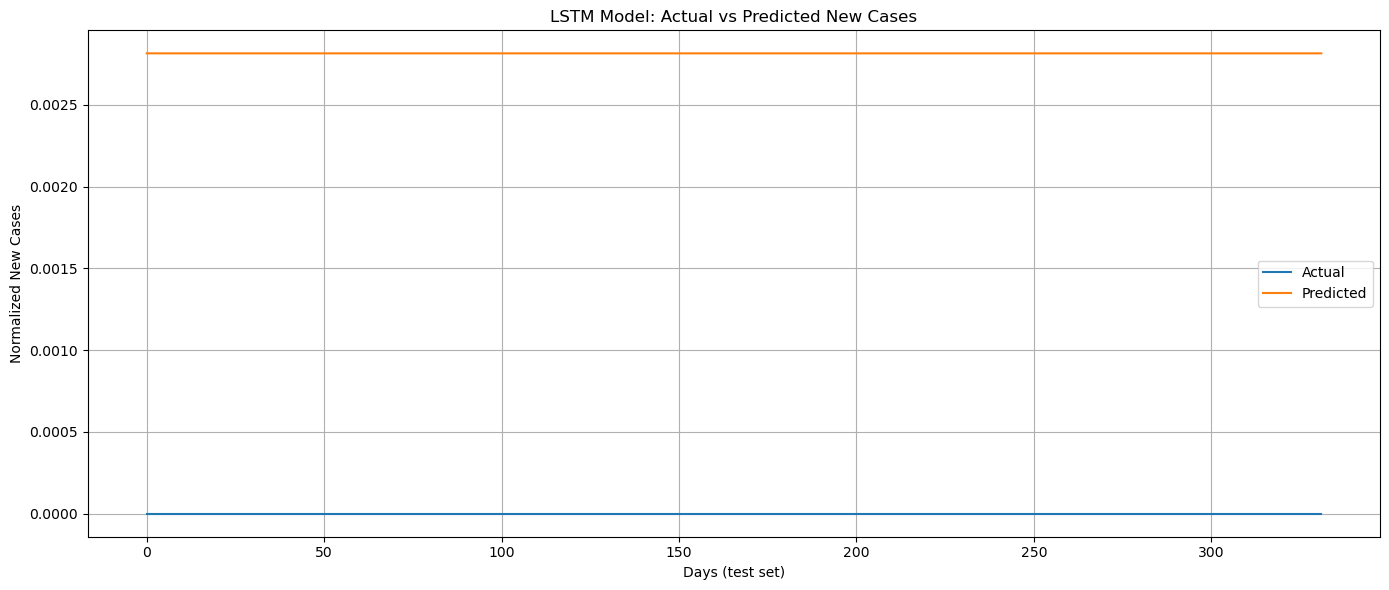

In [107]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM Model: Actual vs Predicted New Cases")
plt.xlabel("Days (test set)")
plt.ylabel("Normalized New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()